In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
import random
from tqdm import tqdm

In [35]:
#Main variables

main_detune = 8
chirp_coeff = 1
power_rate = 1.2
laser_on = 138250
laser_off = 600000

figname = str(main_detune)+'_'+str(chirp_coeff)+ ', '+str(power_rate)


#Define the constants
Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
waist = 0.012/x0
v_max = 20
z_max = 384.855e-3/x0
z_start = 384.855e-3/x0
dz = 0.05/x0
dv = 0.05
v_eval = np.arange(1,26,1)
t_eval = np.linspace(0.,laser_off,laser_off+1)
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3

# The detunings used in the PRAs:
intensity = 2./(np.pi*(0.020)**2)/Isat


#Define the hamiltonian
H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(B=0,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=-1.5/Gamma, q=0, p=0,gJ=-0.00002,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [36]:
#Define the zero magnetic field.

magField = np.zeros(3)

In [37]:
def Fixed_detune_MgF_MOT(main_det,det_coeff,pr):
    det_side = 120/Gamma
    Avg_X = np.average(E_X)
    
    init_pow = 0.15*2./(np.pi*(0.020)**2)/Isat
    power_rate = pr/(2+pr)
    
    def Heav_step(t):
        if t<6e5-7:
            return 1
        elif t>=6e5-7 and t<6e5+7:
            return (t-6e5)*((t-6e5)**2-49*3)*1/686*1/2 + 1/2
        else:
            return 0        
    
    def Chirping(t):
        return det_coeff*t*1e-6
    
    laserBeams = pylcp.laserBeams()
#Switch
#Minus sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : Heav_step(t)*init_pow*0.5*(1-power_rate),
                                                   'delta': lambda t : E_A[-1]-Avg_X-main_det-det_side+Chirping(t)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : Heav_step(t)*init_pow*0.5*(1-power_rate),
                                                   'delta': lambda t : E_A[-1]-Avg_X-main_det-det_side+Chirping(t)}])

#Main part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : Heav_step(t)*init_pow*power_rate,
                                                   'delta': lambda t : E_A[-1]-Avg_X-main_det+Chirping(t)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : Heav_step(t)*init_pow*power_rate,
                                                   'delta': lambda t : E_A[-1]-Avg_X-main_det+Chirping(t)}])
    
#Plus sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : Heav_step(t)*init_pow*0.5*(1-power_rate),
                                                   'delta': lambda t : E_A[-1]-Avg_X-main_det+det_side+Chirping(t)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : Heav_step(t)*init_pow*0.5*(1-power_rate),
                                                   'delta': lambda t : E_A[-1]-Avg_X-main_det+det_side+Chirping(t)}])
# #No-switch
# #Minus sideband part
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : init_pow*0.5*(1-power_rate),
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det-det_side+Chirping(t)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : init_pow*0.5*(1-power_rate),
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det-det_side+Chirping(t)}])

# #Main part
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : init_pow*power_rate,
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det+Chirping(t)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : init_pow*power_rate,
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det+Chirping(t)}])
    
# #Plus sideband part
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : init_pow*0.5*(1-power_rate),
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det+det_side+Chirping(t)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : init_pow*0.5*(1-power_rate),
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det+det_side+Chirping(t)}])

    return laserBeams

In [38]:
laserBeams = Fixed_detune_MgF_MOT(main_detune,chirp_coeff,power_rate)

In [39]:
rateeq = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=False)

In [40]:
zz = np.linspace(-1*z_max,z_max,100)
vv = np.linspace(-1*v_max,v_max+dv,100)
Z,V = np.meshgrid(zz,vv)

# rateeq.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='F',progress_bar=1)

In [41]:
# fig, ax = plt.subplots(1, 1)
# plt.imshow(rateeq.profile['F'].F[2]/mass*1e-3*a0, origin='lower',
#            extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
#                    (np.amin(vv*v0)), (np.amax(vv*v0))),
#            aspect='auto',cmap='gray')
# cb1 = plt.colorbar()
# cb1.set_label('$a\ (\mathrm{km/s^2})$')
# ax.set_xlabel('$z\ (\mathrm{mm})$')
# ax.set_ylabel('$v\ (\mathrm{m/s})$')
# ax.set_title('Force image')
# fig.subplots_adjust(left=0.12,right=0.9)

# # fig.savefig('./Chirping/'+figname+' Force_image.png')

In [42]:
# See solve_ivp documentation for event function discussion:
def captured_condition(t, y, threshold=4):
    if y[-4]<4:
        val = -1.
    else:
        val = 1.

    return val
def lost_condition(t,y):
    if y[-4]>4 and y[-1]>0:
        val = -1
    elif y[-4]<0:
        val = -1
    else:
        val = 1
    return val

def for_transverse_condition(t,y):
    if y[-1]>0:
        val = -1.
    else:
        val = 1.
    return val

captured_condition.terminal=False
lost_condition.terminal=False
for_transverse_condition.terminal = False
conditions =  [captured_condition,lost_condition,for_transverse_condition]

sols_rate = list()

start = time.time()

for v0a in v_eval:
    rateeq.set_initial_position_and_velocity(np.array([0.,0.,-1*z_start]),np.array([0.,0.,v0a]))
    rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
    rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= conditions,progress_bar = 1,method='LSODA')
    sols_rate.append(rateeq.sol)

Completed in 0.47 s.                                                 
Completed in 0.44 s.                                                 
Completed in 0.45 s.                                                 
Completed in 0.46 s.                                                 
Completed in 0.53 s.                                                 
Completed in 0.43 s.                                                 
Completed in 0.50 s.                                                
Completed in 0.56 s.                                                 
Completed in 0.69 s.                                                 
Completed in 0.75 s.                                                 
Completed in 0.76 s.                                                 
Completed in 0.96 s.                                                
Completed in 0.85 s.                                                
Completed in 0.96 s.                                                 
Completed in 1.00 s.   

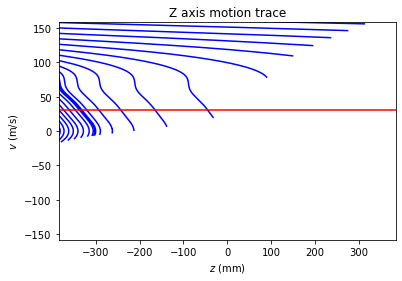

In [43]:
from matplotlib.colors import Normalize

fig, ax = plt.subplots(1, 1)



# plt.imshow(rateeq.profile['F'].F[2]/mass*1e-3*a0, origin='lower',
#            extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
#                    (np.amin(vv*v0)), (np.amax(vv*v0))),
#            aspect='auto',cmap='gray')
# cb1 = plt.colorbar()
# cb1.set_label('$a\ (\mathrm{km/s^2})$')


ax.set_xlabel('$z\ (\mathrm{mm})$')
ax.set_ylabel('$v\ (\mathrm{m/s})$')
ax.set_title('Z axis motion trace')
ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax.set_ylim(-1*v_max*v0,v_max*v0)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax.plot(sol.r[2]*x0*1000,sol.v[2]*v0, 'b')
ax.plot(zz,np.ones(len(zz))*30,'r')

# fig.savefig('./Chirping/'+figname+f', from {v_eval[0]} to {v_eval[-1]}'+' Motion-trace with step fucntion.png') 
# fig.savefig('./Chirping/'+figname+' Sine Motion-trace.png')
# fig.savefig('./PR/Chirpin motion trace.png')

In [44]:
for sol in sols_rate:
    if len(sol.t_events[2])==1:
        print(sol.v[2][0])

16.0
17.000000000000004
18.000000000000004
19.0
20.0
21.0
22.0
23.000000000000004
24.0
25.0


In [34]:
0.001/t0

138230.07675795088

In [45]:
laserBeams.intensity(t=100001)

array([0.1203442 , 0.1203442 , 0.14441304, 0.14441304, 0.1203442 ,
       0.1203442 ])